In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchviz import make_dot
from torchinfo import summary
import numpy as np

In [2]:
print(torch.cuda.is_available())

True


In [3]:
print(torch.cuda.device_count())

1


## VAE

In [4]:
class Encoder(nn.Module):
    """Encoder"""

    def __init__(self, z_dim=32):
        super().__init__()
        self.z_dim = z_dim

        self.conv1 = nn.Conv2d(3, 32, 4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2) 
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2)

        self.mu = nn.Linear(256*2*2, z_dim)
        self.logvar = nn.Linear(256*2*2, z_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        # x: [batch_size, 3, 64, 64]
        c1 = self.conv1(x) # (64x64x3) -> (31x31x32)
        h1 = self.relu(c1) # (31x31x32) -> (31x31x32)
        c2 = self.conv2(h1) # (31x31x32) -> (14x14x64)
        h2 = self.relu(c2) # (14x14x64) -> (14x14x64)
        c3 = self.conv3(h2) # (14x14x64) -> (6x6x128)
        h3 = self.relu(c3) # (6x6x128) -> (6x6x128)
        c4 = self.conv4(h3) # (6x6x128) -> (2x2x256)
        h4 = self.relu(c4) # (2x2x256) -> (2x2x256)

        d1 = h4.view(-1, 256*2*2) # (2x2x256) -> (1024)

        mu = self.mu(d1) # (1024) -> (32)
        logvar = self.logvar(d1) # (1024) -> (32)
        var = torch.exp(logvar)
        std = torch.sqrt(var)

        ep = torch.randn_like(std)

        z = mu + ep * std # (32) -> (32)

        return z, mu, logvar

In [5]:
class Decoder(nn.Module):
    """Decoder"""
    def __init__(self, z_dim=32):
        super().__init__()
        self.z_dim = z_dim

        self.l1 = nn.Linear(z_dim, 1024*1*1)

        self.deconv1 = nn.ConvTranspose2d(1024, 128, 5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 6, stride=2)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        # z: [batch_size, 32]
        d1 = self.l1(z) # (32) -> (1024)
        d1 = d1.view(-1, 1024, 1, 1) # (1024) -> (1x1x1024)

        dc1 = self.deconv1(d1) # (1x1x1024) -> (5x5x128)
        h1 = self.relu(dc1) # (5x5x128) -> (5x5x128)
        dc2 = self.deconv2(h1) # (5x5x128) -> (13x13x64)
        h2 = self.relu(dc2) # (13x13x64) -> (13x13x64)
        dc3 = self.deconv3(h2) # (13x13x64) -> (30x30x32)
        h3 = self.relu(dc3) # (30x30x32) -> (30x30x32)
        dc4 = self.deconv4(h3) # (30x30x32) -> (64x64x3)
        x = self.sigmoid(dc4) # (64x64x3) -> (64x64x3)

        return x

In [6]:
class VAE(nn.Module):
    '''VAE'''
    def __init__(self, z_dim=32):
        super().__init__()
        self.z_dim = z_dim

        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x = self.decoder(z)

        return x, mu, logvar
    
    def encoder(self, x):
        return self.encoder(x)
    
    def decoder(self, z):
        return self.decoder(z)

In [7]:
encoder = Encoder()

In [8]:
summary(encoder, (3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 32]                   --
├─Conv2d: 1-1                            [32, 31, 31]              1,568
├─ReLU: 1-2                              [32, 31, 31]              --
├─Conv2d: 1-3                            [64, 14, 14]              32,832
├─ReLU: 1-4                              [64, 14, 14]              --
├─Conv2d: 1-5                            [128, 6, 6]               131,200
├─ReLU: 1-6                              [128, 6, 6]               --
├─Conv2d: 1-7                            [256, 2, 2]               524,544
├─ReLU: 1-8                              [256, 2, 2]               --
├─Linear: 1-9                            [1, 32]                   32,800
├─Linear: 1-10                           [1, 32]                   32,800
Total params: 755,744
Trainable params: 755,744
Non-trainable params: 0
Total mult-adds (M): 400.37
Input size (MB): 0.05
Forward/

In [9]:
decoder = Decoder()

In [10]:
summary(decoder, (32,))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1, 3, 64, 64]            --
├─Linear: 1-1                            [1024]                    33,792
├─ConvTranspose2d: 1-2                   [1, 128, 5, 5]            3,276,928
├─ReLU: 1-3                              [1, 128, 5, 5]            --
├─ConvTranspose2d: 1-4                   [1, 64, 13, 13]           204,864
├─ReLU: 1-5                              [1, 64, 13, 13]           --
├─ConvTranspose2d: 1-6                   [1, 32, 30, 30]           73,760
├─ReLU: 1-7                              [1, 32, 30, 30]           --
├─ConvTranspose2d: 1-8                   [1, 3, 64, 64]            3,459
├─Sigmoid: 1-9                           [1, 3, 64, 64]            --
Total params: 3,592,803
Trainable params: 3,592,803
Non-trainable params: 0
Total mult-adds (M): 231.70
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 14.37
Estimated Tota

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE()

In [12]:
summary(vae, (3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 3, 64, 64]            --
├─Encoder: 1-1                           [1, 32]                   --
│    └─Conv2d: 2-1                       [32, 31, 31]              1,568
│    └─ReLU: 2-2                         [32, 31, 31]              --
│    └─Conv2d: 2-3                       [64, 14, 14]              32,832
│    └─ReLU: 2-4                         [64, 14, 14]              --
│    └─Conv2d: 2-5                       [128, 6, 6]               131,200
│    └─ReLU: 2-6                         [128, 6, 6]               --
│    └─Conv2d: 2-7                       [256, 2, 2]               524,544
│    └─ReLU: 2-8                         [256, 2, 2]               --
│    └─Linear: 2-9                       [1, 32]                   32,800
│    └─Linear: 2-10                      [1, 32]                   32,800
├─Decoder: 1-2                           [1, 3, 64, 64]     

In [13]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

In [14]:
transform_data = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [15]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_data)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_data)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
def criterion(predict, target, ave, log_dev):
  bce_loss = F.binary_cross_entropy(predict, target, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = bce_loss + kl_loss
  return loss

net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
history = {'train_loss': []}

epochs = 10

for epoch in range(epochs):
    for i, (img, _) in enumerate(train_loader):
        img = img.to(device)
        output, mu, logvar = net(img)
        loss = criterion(output, img, mu, logvar)
        history['train_loss'].append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

epoch: 0, step: 0, loss: 1090621.375
epoch: 0, step: 100, loss: 989722.9375


KeyboardInterrupt: 

In [ ]:
g = make_dot(output, params=dict(net.named_parameters()))
g.view()

'Digraph.gv.pdf'

## MDN-RNN

In [17]:
class LayerNormBasicLSTM(nn.Module):
    """LSTM"""
    def __init__(self, z_size, a_size, hidden_size=256, num_layers=1):
        super().__init__()
        self.z_size = z_size
        self.a_size = a_size
        self.input_size = z_size + a_size
        self.lstm = nn.LSTM(self.input_size, hidden_size, num_layers, batch_first=False) # LSTM：入力サイズ、隠れ層サイズ、層数、バイアス、バッチファースト

    def forward(self, x):
        # x: [seq_len, batch_size, z_size + a_size]
        output, (h_n, c_n) = self.lstm(x)
        # output: [seq_len, batch_size, hidden_size]
        # h_n: [num_layers, batch_size, hidden_size]
        # c_n: [num_layers, batch_size, hidden_size]
        return output, (h_n, c_n)


In [18]:
class MDN(nn.Module):
    """Mixture Density Network"""
    def __init__(self, hidden_size=256, z_size=32, r_size=0, num_gaussians=5):
        super().__init__()
        self.hidden_size = hidden_size
        self.z_size = z_size
        self.num_gaussians = num_gaussians
        self.output_size = num_gaussians * 3 *  z_size + r_size # 3: mu, sigma, pi, r_size: reward

        self.fc = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x):
        # x: [seq_len, batch_size, hidden_size]
        output = self.fc(x)
        # output: [seq_len, batch_size, num_gaussians * 3 * z_size + r_size]
        p, mu, sigma, r = self.split_mdn_params(output)

        return p, mu, sigma, r
    
    def split_mdn_params(self, output):
        # output: [seq_len, batch_size, num_gaussians * 3 * z_size + r_size]
        p = output[:, :, :self.num_gaussians]
        mu = output[:, :, self.num_gaussians:self.num_gaussians * (self.z_size + 1)]
        sigma = output[:, :, self.num_gaussians * (self.z_size + 1):self.num_gaussians * (self.z_size * 2 + 1)]
        r = output[:, :, -1]

        # p: [seq_len, batch_size, num_gaussians]
        # mu: [seq_len, batch_size, num_gaussians * z_size]
        # sigma: [seq_len, batch_size, num_gaussians * z_size]
        # r: [seq_len, batch_size, r_size]

        p = F.softmax(p, dim=2)
        sigma = torch.exp(sigma)
        return p, mu, sigma, r

In [19]:
class MDRNN(nn.Module):
    """MDN-RNN"""
    def __init__(self, z_size, a_size, r_size, hidden_size=256, num_layers=1, num_gaussians=5):
        super().__init__()
        self.z_size = z_size
        self.a_size = a_size
        self.r_size = r_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_gaussians = num_gaussians

        self.lstm = LayerNormBasicLSTM(z_size, a_size, hidden_size, num_layers)
        self.mdn = MDN(hidden_size, z_size, r_size, num_gaussians)

    def forward(self, z, a):
        # z: [seq_len, batch_size, z_size]
        # a: [seq_len, batch_size, a_size]
        za = torch.cat([z, a], dim=2)
        # za: [seq_len, batch_size, z_size + a_size]
        output, (h_n, c_n) = self.lstm(za)
        # output: [seq_len, batch_size, hidden_size]
        # h_n: [num_layers, batch_size, hidden_size]
        # c_n: [num_layers, batch_size, hidden_size]
        p, mu, sigma, r = self.mdn(output)
        # p: [seq_len, batch_size, num_gaussians]
        # mu: [seq_len, batch_size, num_gaussians * z_size]
        # sigma: [seq_len, batch_size, num_gaussians * z_size]
        # r: [seq_len, batch_size, r_size]
        return output, p, mu, sigma, r


In [20]:
lstm = LayerNormBasicLSTM(32, 3)

In [21]:
summary(lstm, (1, 1, 35))

Layer (type:depth-idx)                   Output Shape              Param #
LayerNormBasicLSTM                       [1, 1, 256]               --
├─LSTM: 1-1                              [1, 1, 256]               300,032
Total params: 300,032
Trainable params: 300,032
Non-trainable params: 0
Total mult-adds (M): 0.30
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.20
Estimated Total Size (MB): 1.20

In [22]:
mdn = MDN(256, 32, 0)

In [23]:
summary(mdn, (1, 1, 256))

Layer (type:depth-idx)                   Output Shape              Param #
MDN                                      [1, 1, 5]                 --
├─Linear: 1-1                            [1, 1, 480]               123,360
Total params: 123,360
Trainable params: 123,360
Non-trainable params: 0
Total mult-adds (M): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.49
Estimated Total Size (MB): 0.50

In [24]:
mdnrnn = MDRNN(32, 3, 0)

In [25]:
summary(mdnrnn, [(1, 1, 32), (1, 1, 3)])

Layer (type:depth-idx)                   Output Shape              Param #
MDRNN                                    [1, 1, 256]               --
├─LayerNormBasicLSTM: 1-1                [1, 1, 256]               --
│    └─LSTM: 2-1                         [1, 1, 256]               300,032
├─MDN: 1-2                               [1, 1, 5]                 --
│    └─Linear: 2-2                       [1, 1, 480]               123,360
Total params: 423,392
Trainable params: 423,392
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.69
Estimated Total Size (MB): 1.70

In [6]:
class Controller(nn.Module):
    """Controller"""

    def __init__(self, a_size, h_size=256, z_size=32):
        super().__init__()
        self.a_size = a_size
        self.h_size = h_size
        self.z_size = z_size
        self.input_size = z_size + h_size
        self.fc = nn.Linear(self.input_size, a_size)

    def forward(self, z, h):
        # z: [batch_size, z_size]
        # h: [batch_size, h_size]
        zh = torch.cat([z, h], dim=1)
        # zh: [batch_size, z_size + h_size]
        a = self.fc(zh)
        # a: [batch_size, a_size]
        return a

In [7]:
c = Controller(3)

summary(c, [(1, 32), (1, 256)])

Layer (type:depth-idx)                   Output Shape              Param #
Controller                               [1, 3]                    --
├─Linear: 1-1                            [1, 3]                    867
Total params: 867
Trainable params: 867
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Env

In [56]:
import gym
from gym.spaces.box import Box
from gym.envs.box2d.car_racing import CarRacing
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr

In [72]:
env = gym.make('CarRacing-v2')
state, _ = env.reset()

In [60]:
img.size

(96, 96)

In [ ]:
SCREEN_X = 64 # 画像の横幅
SCREEN_Y = 64 # 画像の縦幅

In [48]:
#ゲームの選択
env = gym.make('CarRacing-v2', render_mode='rgb_array')

#デフォルトのactionsの確認（steer, gas, brakeの3次元連続値）
print('env.action_space: {}'.format(env.action_space))

#アクションを離散値で用意しておく
actions = np.array([[ 0, 0, 0],  #actions[0]：何もしない（＝等速直線運動）
                    [ 0, 1, 0],  #actions[1]：加速
                    [ 0, 0, 1],  #actions[2]：減速
                    [ 1, 0, 0],  #actions[3]：右旋回
                    [-1, 0, 0]]) #actions[4]：左旋回
print('actions:\n{}'.format(actions))

env.action_space: Box([-1.  0.  0.], 1.0, (3,), float32)
actions:
[[ 0  0  0]
 [ 0  1  0]
 [ 0  0  1]
 [ 1  0  0]
 [-1  0  0]]


In [126]:
import tqdm
import os

env = gym.make('CarRacing-v2', render_mode='rgb_array')

def get_rollouts(num_rollouts=10000, reflesh_rate=20, file_dir='./data/'):
    for i in tqdm.tqdm(range(num_rollouts)):
        state_sequence = []
        action_sequence = []
        reward_sequence = []
        done_sequence = []
        state = env.reset()
        done = False
        iter = 0
        while not done:
            if iter % reflesh_rate == 0:
                if iter < 20:
                    steering = -0.1
                    acceleration = 1
                    brake = 0
                else:
                    steering = nr.uniform(-1, 1)
                    acceleration = nr.uniform(0, 1)
                    brake = nr.uniform(0, 1)
            action = np.array([steering, acceleration, brake])
            state, reward, done, _, _ = env.step(action)
            state = reshape_state(state)
            state_sequence.append(state)
            action_sequence.append(action)
            reward_sequence.append(reward)
            done_sequence.append(done)
            iter += 1
        np.savez_compressed(os.path.join(file_dir, 'rollout_{}.npz'.format(i)), state=state_sequence, action=action_sequence, reward=reward_sequence, done=done_sequence)

def load_rollout(idx_rolloout, file_dir='./data/'):
    data = np.load(os.path.join(file_dir, 'rollout_{}.npz'.format(idx_rolloout)))
    return data['state'], data['action'], data['reward'], data['done']

def reshape_state(state):
    HEIGHT = 64
    WIDTH = 64
    state = state[0:84, :, :]
    state = np.array(Image.fromarray(state).resize((HEIGHT, WIDTH)))
    state = state / 255.0
    return state
    


In [121]:
state[0].shape

(96, 96, 3)

In [122]:
reshape_state(state[0]).shape

(64, 64, 3)

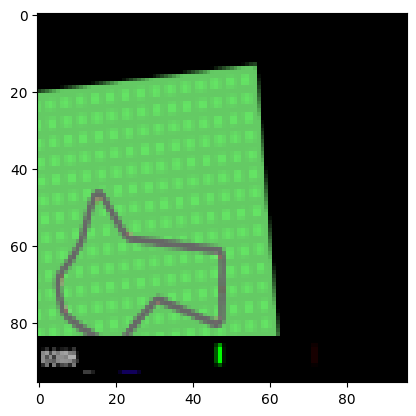

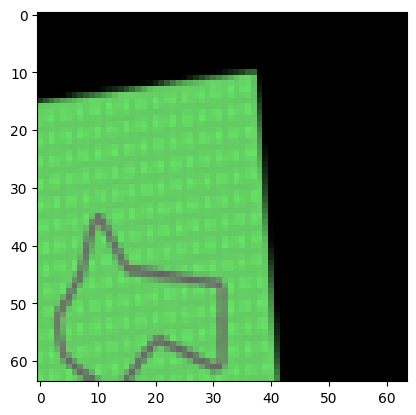

In [123]:
import matplotlib.pyplot as plt

plt.imshow(state[0])
plt.show()

plt.imshow(reshape_state(state[0]))
plt.show()

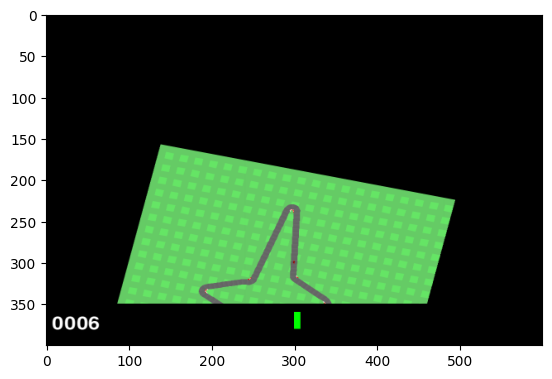

c:\Users\daiki\miniconda3\envs\env_torch_world_models\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


reward:6.725938566552902
reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964


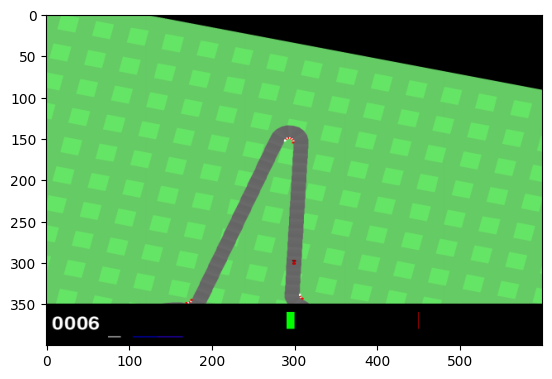

reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964


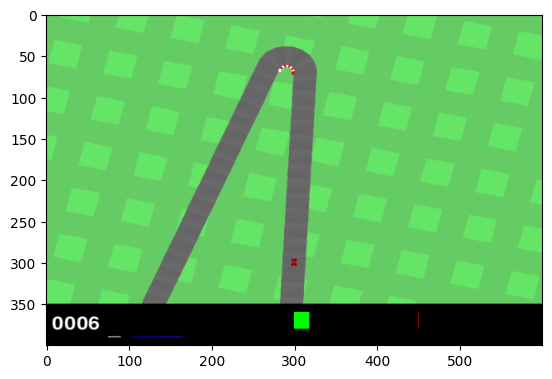

reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964


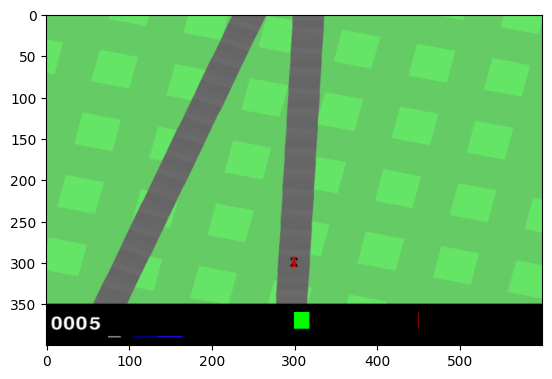

reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964


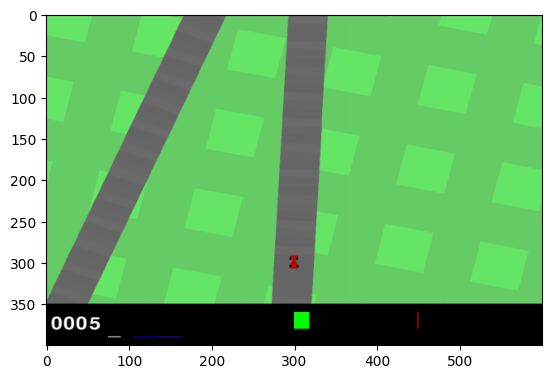

reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964


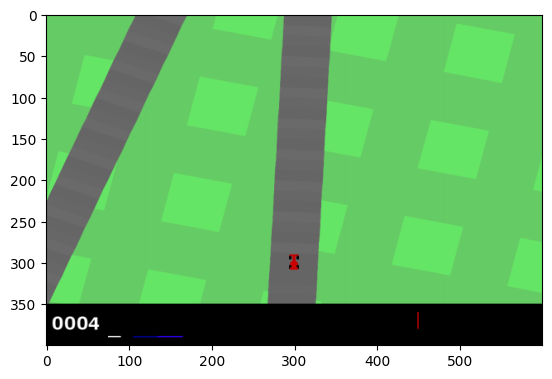

reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964


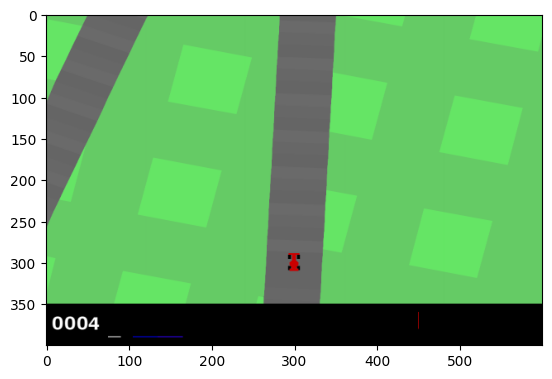

reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964
reward:-0.09999999999999964


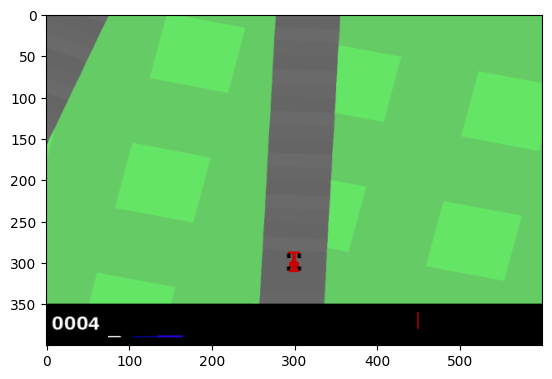

reward:-0.10000000000000009
reward:-0.10000000000000009
reward:-0.10000000000000009
reward:-0.10000000000000009


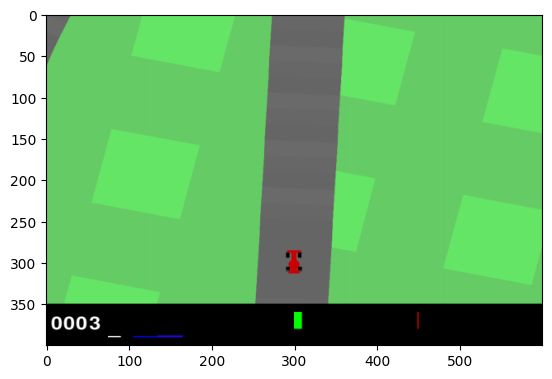

reward:-0.10000000000000009
reward:-0.10000000000000009
reward:-0.10000000000000009
reward:-0.10000000000000009


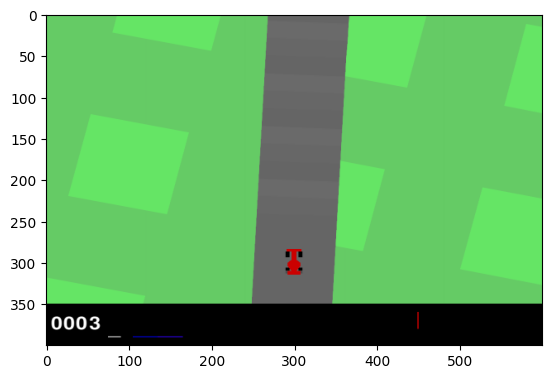

reward:-0.10000000000000009
reward:-0.10000000000000009
reward:-0.10000000000000009
reward:-0.10000000000000009


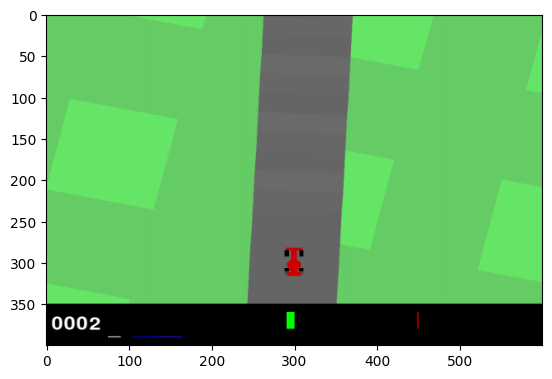

In [124]:
state, _ = env.reset()

#初期画像を表示
plt.figure()
plt.imshow(env.render())
plt.show()

#ランダムにアクション（1アクションは4フレーム継続）
for i in range(10):
    for _ in range(4):
        #アクションの選択
        rand = nr.randint(5)

        #状態の更新
        state, reward, done, info, _ = env.step(actions[rand])
        print('reward:{}'.format(reward))
        
    #1アクション（＝4フレーム）毎に画像を表示
    plt.figure()
    plt.imshow(env.render())
    plt.show()

In [36]:
env.reset()

observation, reward, done, info, _ = env.step(env.action_space.sample())

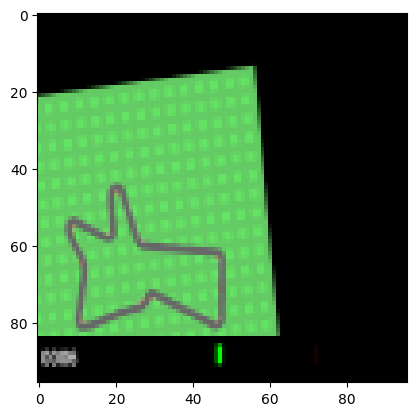

In [37]:
plt.imshow(observation)